# Helpers and imports

In [2]:
from sklearn import datasets
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cvx
import numpy as np
import random


def plot_3D(X_reduced,y,
            fig,plot_name,
            pos,rstride, cstride,
            ):
    
    #To getter a better understanding of interaction of the dimensions
    # plot the first three PCA dimensions
    
    
    ax = fig.add_subplot(1, pos, 1, projection='3d')
    ax.scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        X_reduced[:, 2],
        c=y,
        cmap=plt.cm.Set1,edgecolor="k",s=40,
        #rstride = rstride,cstride=cstride,
        
    )
    ax.set_title(plot_name)
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])

def plot_embeds(X_pca,X_spca,y):
    
    # set up a figure twice as wide as it is tall
    #fig = plt.figure(figsize=plt.figaspect(0.20))
    fig = plt.figure(figsize=(25,5))
    plot_3D(X_spca,y,fig,"SPCA",2,10,10)
    plot_3D(X_pca,y,fig,"PCA",1,1,1)
    plt.show()
    
    

# SPCA Code 

We solve the optimization using CVXPY, a modeler that uses very pythonesque syntax.

We use the SCS default solver for the SDP.



In [3]:
def project_spca(n_components,A,s):
    """  Projects matrix A into the subspace spanned by the DSCPA.
    
    Returns:
        ndarray: Matrix A projected into the DSCPA direction.
    """
    
    C = np.cov(A,rowvar=False)     
    spca = compute_pca_directions(C,n_components,s)
    A_reduced =  A @ spca
    
    return A_reduced
    
    
def compute_pca_directions(C,n_components,s):
    
    """Compute n_components of DSCPA decomposition.
    Each component spans at most k dimensions.
    
    Args:
        n_components (int): number of computed directions.
        C (ndarray): Covariance matrix : MUST BY SYMMETRICAL !!
        s (int): number of components in each direction

    Returns:
        ndarray: the directions of PCA
    """
    
    rslt = np.zeros((C.shape[0],n_components))
    
    for i in range(n_components):
        
        value,sol = solve_sdp(C,s)
        eigvals, eigvecs = np.linalg.eigh(sol)
        x = eigvecs[:,np.argmax(eigvals)].reshape(-1,1)  ## x such that  X = x@x.T
        rslt[:,i] = x.squeeze()
        C = C - value * sol  ## C = C-(x.T@C@x) * (x@x.T)
        
        # print("Rank X =",np.linalg.matrix_rank(sol))
        # print("x has ",np.)sum(abs(x)>1e-1) ,"sparse components")
        

        
    return rslt
 
def solve_sdp(C, s):
    
    """Compute a solution the s-sparse PCA of A.

    Args:
        A (ndarray): Matrix to extract the sub-matrix from
        s (int): Sparsity level for the lower bound.

    Returns:
        (int,ndarray): value and optimal point
    """
    
    n_dim = C.shape[0]
    
    X = cvx.Variable((n_dim, n_dim),symmetric=True)
    
    pb = cvx.Problem(cvx.Maximize(cvx.trace(C@X)),
                     [X >> 0, ## X positive semidefinite
                     cvx.trace(X) - 1 == 0,
                     cvx.sum(cvx.abs(X))-s <= 0 
                     ])   
       
    pb.solve(verbose=False, max_iters=100000)
    
    return pb.value,X.value

# SPCA Tests

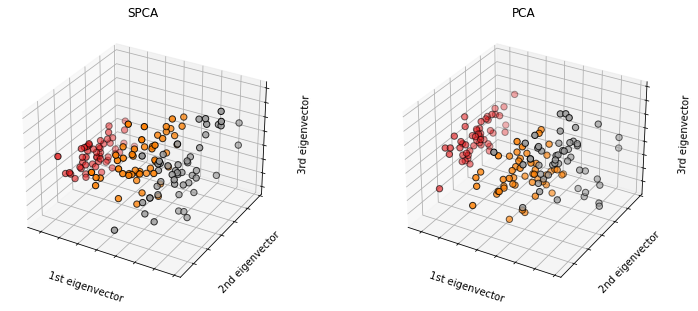

In [4]:
iris = datasets.load_iris()
X = iris.data 
X = X - np.mean(X , axis = 0) 
y = iris.target

X_pca  = PCA(n_components=3).fit_transform(X)
X_spca = project_spca(n_components=3,A=X,s=3)
plot_embeds(X_pca,X_spca,y)

# Justification of the DSCPA formulation : 

This section is only technical, we detail the computations of the SDP formulation of SPCA.

## Primal \& Dual : 
\begin{array}{ c c l }
Primal\ : & \max_{x\in \mathbb{R}^{n}} & x^{T} Ax\\
 & subject\ to & \ \Vert x\Vert _{2}^{2} =1
\end{array}

\begin{array}{l}
\begin{aligned}
\mathcal{L}( x,u) & =\ x^{T}( A-u.I_{n}) x\ +\ u\\
\theta ( u) & =sup_{x}\mathcal{L}( x,u)\\
 & =\ 
 \begin{cases}
    +\infty \  & \ if\ A-u.I_{n} \ \in S_{n}^{++}\\
    u\ \ \  & else
\end{cases}
\end{aligned} \ \ \\
\\
\end{array}


\begin{array}{ c c l c c }
Dual: & min_{u\in \mathbb{R}} & u & = & \lambda ^{max}( A)\\
 & subject\ to & A-u.I_{n} \ \in S_{n}^{-} &  & 
\end{array}

There is no equality constraints on the primal, slater conditions apply and duality gap is zero.

## Lagrangian of the dual 

We can rewrite the dual by adding a slack variable $v$ : 

\begin{array}{ c l l }
Dual\ :\  & min_{u\in \mathbb{R}}{} & u\\
 & s.t & g( u) \ \in \ K:=\ S_{n}^{-} \ \\
 &  & \\
= & min_{u,v\in \mathbb{R} ²}{} & u\\
 & s.t & v\ \in \ K\ \\
 &  & g( u) =v\\
 &  & 
\end{array}\\

With this formulation, the support function appears in the dual:

\begin{aligned}

    \begin{aligned}
        \tilde{\mathcal{L}}( u,v,X)
    \end{aligned}

    & =\ u\ +\ < X,g( u) -v >\\

    \tilde{\theta }( X) & =\ \inf_{u,v}\tilde{\mathcal{L}}( u,v,X)\\
    & =\ \inf_{u}\inf_{v\in K} \ ( u\ +\ < X,g( u)  >\ -< X,v >)\\
    & =\ \inf_{u} \ \ u\ +\ < X,g( u)  >\ +\ \inf_{v\in K} \ -< X,v >\\
    & =\ \inf_{u} \ \mathcal{L}( u,X) \ -\ \sigma _{K}( X) \ ( **)
\end{aligned}\\

(**) Recall the property of a support function over a convex cone $K$: 
\begin{aligned}
\sigma _{K}( X)  :\  & =\ 
\begin{cases}
0 & if\ X\ \in \tilde{K} \ :=\{U\ :\ < U,Y >\ \leq 0\ \ \forall Y\ \in K\}\\
+\ \infty  & else
\end{cases}
\end{aligned}

 ## Dual of the dual (Lifting): 
 
One can prove that $\widetilde{S_{n}^{-}} =S_{n}^{+} $ allowing to rewrite the lagrangian as :

\begin{array}{l}

\begin{aligned}
\tilde{\theta }( X) & =\ \inf_{u} \ u\ +\ < X,A-u.I_{n}  >\\
 & =\ < X,A >+\ \ \inf_{u} \ u\ ( \ 1\ -\ < X,I_{n}  >)\\
 & =\ Tr( X A) +\ \ \inf_{u} \ u\ ( \ 1\ -\ Tr( X)) \ \ \ \ \ \left[ *:\ X\ =\ X^{T}\right]\\
 & =\ 
    \begin{cases}
        0 & if\ Tr( X) \ \leq \ 1\\
        -\ \infty  & else
    \end{cases}
\end{aligned}
\end{array}



\begin{array}{ c c l }
\begin{aligned}
Lifting:  & 
\end{aligned} \  & max_{X} & Tr( XA)\\
 & subject\ to & X\ \succsim \ 0\\
 &  & Tr( X) \ =1\ ( **)
\end{array}\\


(**) We can show that the trace inequality is in fact an equality.

Indeed, if $X^*$ is a solution of L such that $Tr(X^*) \ =\alpha < \ 1$

Then $\tilde{X} \ =\ \frac{1}{\alpha } \ X^*$ is a valid point and $Tr\left(\tilde{X} A\right) \ =\ \frac{1}{\alpha } \ Tr(X^* A) \  >Tr(X^* A)$.


By taking $u = \lambda ^{max}( A) + 1 $ we have that $A-u.I_{n} \ \in S_{n}^{--}$ 

The conic slater conditions hold for the dual problem thus the duality gap between Dual and Lifting is zero.

## Simplify Lifting : 

Denote by val = value(L) = value (P): 
\begin{array}{l}
\\
\exists x^{*} \ \in \mathbb{R}^{n} \ s.t\ \left\Vert x^{*}\right\Vert _{2}^{2} =1\ \ and\ < x^{*} ,Ax^{*}  >\ =\ val\\
\Longrightarrow \exists x^{*} ,\ s.t\ \ Tr\left( x^{*} x{^{*}}^{T}\right) \ =\ 1,\ \ \ < x^{*} x{^{*}}^{T} ,A >\ =\ val\\
\Longrightarrow \ \exists X^{*} =x^{*} x{^{*}}^{T} \ \ s.t,\ X^{*} \ \succsim \ 0,\ Tr\left( X^{*}\right) \ =1\ ,Rank\left( X^{*}\right) \ =\ 1\ \ and\ X^{*} \ solution\ of\ DD.\\

\end{array}

Thus the search space of L can be further simplified : 

\begin{array}{ l l l }
L\ :\  & max_{X} & Tr( XA)\\
 & subject\ to & X\ \succsim \ 0\\
 &  & Tr( X) \ =1\\
 &  & Rank( X) =1
\end{array}\\




## SDP formulation of SPCA : 

One can find the SDP formulation of SPCA by simply adding the cardinality constraint on x and then by equivalence to $X = xx^T$

\begin{array}{l}

\begin{array}{ c c l }
\begin{aligned}
SCPA\  & :
\end{aligned} \  & max_{X} & Tr( XA) \ \\
 & subject\ to & X\ \succsim \ 0\\
 &  & Tr( X) \ =1\\
 &  & Rank( X) =1\\
 &  & Card( X) \ \leq \ k²
\end{array}\\
\end{array}

The cardinality constraint is an integer constraint it can be relaxed.

We also drop the rank constriant we will justify later.

 \begin{array}{l}
\begin{array}{ c c l }
\begin{aligned}
SCPA\  & :
\end{aligned} \  & max_{X} & Tr( XA) \ -\ \rho \ \mathbb{1}^{T} |X|\mathbb{1}\\
 & subject\ to & X\ \succsim \ 0\\
 &  & Tr( X) \ =1
\end{array}\\
\end{array}


We rewrite the penalty as an optimization problem.

\begin{array}{l}
\begin{aligned}
-\rho \ \mathbb{1}^{T} |X|\mathbb{1} \  & = & -\rho \sum _{i,j} |X_{ij} | & = & min_{U}\sum _{i,j} U_{ij} X_{ij} \  & = & min_{U} Tr( XU)\\
 &  &  &  & s.t\ |U_{ij} |\ \leqslant \ \rho  &  & \ \ s.t\ |U_{ij} |\ \leqslant \ \rho 
\end{aligned}
\end{array}

We can see a maxmin form of SCPA : 

 \begin{array}{l}
\begin{array}{ c c c c }
 & \max_{X} \ \ \min_{U} & \ \ \mathbf{Tr} \ ( X( A+U)) & \\
 & X\ \succsim \ 0,Tr( X) \ =1 &  & \\
 & \ |U_{ij} |\ \leqslant \ \rho  &  & 
\end{array}\\
\end{array}

Its dual is the minmax : 

\begin{array}{ c c c c }
\min_{U} & \ \max_{X} \ \ \ \mathbf{Tr} \ ( X( A+U)) & = & \min_{U} \ \mathbf{\lambda }^{max}( A+U)\\
\ |U_{ij} |\ \leqslant \ \rho  & X\ \succsim \ 0,Tr( X) \ =1 &  & \ |U_{ij} |\ \leqslant \ \rho \\
 &  &  & 
\end{array}

## Justification for rank constraint : 


In the maxmin formulation, by taking $X = \frac{1}{N}I_N$ we get the conic slater conditions and both problems are equivalent.

Thus, by applying KKT conditions to the primal and dual we get : 



The KKT conditions can be further simplified: 

\begin{cases}
X^{*} \ maximizes\ \mathcal{L}\left( .,U^{*}\right) :\  & ( A+U) \ X\ =\ \mathbf{\lambda }^{max}\left( A+U^{*}\right) X\ \ \ \ ( **)\\
Complementary\ slackness:\  & \ X^{*} \ \odot \ U^{*} \thinspace =\ |\ X^{*} |\\
Primal\ feasible\ :\  & X^{*} \ \succsim \ 0,Tr\left( X^{*}\right) \ =1\\
Dual\ feasible\ :\  & \ |U_{ij}^{*} |\ \leqslant \ \rho \ \ \ 
\end{cases}




 \begin{array}{l}
\mathbf{(**) \ :\ Tr} \ \left( X^{*}\left( A+U^{*}\right)\right) \ \underset{Von-Neumann}{\leq } \ \sum _{i} \sigma _{i}\left( X^{*}\right) \sigma _{i}\left( A+U^{*}\right) \ \\
\leq \ \sum _{i} \sigma _{i}\left( X^{*}\right) \ \mathbf{\lambda }^{max}\left( A+U^{*}\right) \ \underset{\sum _{i} \sigma _{i}\left( X^{*}\right) =1}{\leq } \ \mathbf{\lambda }^{max}\left( A+U^{*}\right)
\end{array}

We are dealing with covariance matrices of random data, thus one can suppose that the eigenvalue $\lambda^{max}(A+U)$ is simple (b).

In this case, we get equality iff :

$$\sigma _{1}\left( X^{*}\right) \ =1\ \ and\ \sigma _{i}\left( X^{*}\right) =0\ \forall i\neq 1\Longrightarrow \ Rank\left( X^{*}\right) \ =\ 1.$$

 \begin{array}{l}
\sigma _{1}\left( X^{*}\right) \ =1\ \ and\ \sigma _{i}\left( X^{*}\right) =0\ \forall i\neq 1\Longrightarrow \ Rank\left( X^{*}\right) \ =\ 1\\
\Longrightarrow \ \exists x^{*} \in \mathbb{R}^{n} \ such\ that\ \ X^{*} \ =\ x^{*} x{^{*}}^{T} \ \ ( c)\\
\\
( a) \ +( b) +( c) :\ 
\begin{drcases}
< \left( A+U^{*}\right) x^{*} ,x^{*}  >\ =\ \mathbf{\lambda }^{max}\left( A+U^{*}\right)\\
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \left\Vert x^{*}\right\Vert _{2}^{2} \ =1\ \ \\
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \mathbf{\lambda }^{max} \ is\ simple\ 
\end{drcases} \ \ \\
\\
\Longrightarrow \ x^{*} \ is\ the\ principal\ component\ of\ \left( A+U^{*}\right) \ =\ v^{max} \ \left( A+U^{*}\right) \ \\
\Longrightarrow \ \left( A+U^{*}\right) X^{*} \ =\ \left( A+U^{*}\right) x^{*} x{^{*}}^{T} =\ \mathbf{\lambda }^{max}\left( A+U^{*}\right) x^{*} x{^{*}}^{T} \ =\ \mathbf{\lambda }^{max}\left( A+U^{*}\right) X^{*}\\
\end{array}

# Planted clique problem

In [5]:
def bernoulli(p):
    if np.random.random() < p:
        return 1
    return 0

def random_sample(k,n):
    l = [i for i in range(n)]
    return random.sample(l,k)
    
def PlantedClique(k,p,n):
    
    A = np.zeros((n,n), dtype=int)
    for i in range(n) :
        for j in range(n) :
            A[i,j] = bernoulli(p)
            A[j,i] = A[i,j]
    clique = random_sample(k,n)
    
    
    for i in clique :
        for j in clique :
            if i!=j :
                A[i,j] = 1
                A[j,i] = 1
                
    return A,clique


In [22]:
n,k,p = 100,20,0.3


Adj,clique_idx = PlantedClique(k,p,n)
B = Adj - p * np.ones_like(Adj)

b_spca = compute_pca_directions(B,n_components=1,s=k)
b_pca  = PCA(n_components=1).fit_transform(B)

def plot_clique_embeds(x,clique_idx,ax=None,title=None):
    
    if ax is None: ax = plt.gca()
    
    ax.plot(abs(x),linestyle="",marker="o",label="embedding")
    true = np.zeros_like(x)
    true[clique_idx] = abs(x)[clique_idx]
    ax.plot(true,marker="x",color="red",label="true clique")
    ax.set_title(title)
    ax.legend()
    

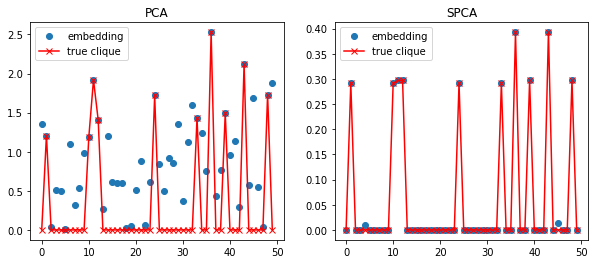

In [21]:
fig,axs = plt.subplots(1,2,figsize=(10,4))
plot_clique_embeds(b_pca,clique_idx,axs[0],"PCA")
plot_clique_embeds(b_spca,clique_idx,axs[1],"SPCA")